In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.9MB/s eta 0:00:011
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 43.7MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 194kB 59.3MB/s eta 0:00:01
    100% |████████████████████████████████| 10.4MB 5.2MB/s eta 0:00:011
    100% |████████████████████████████████| 7.1MB 7.4MB/s eta 0:00:011
    100% |████████████████████████████████| 61kB 44.6MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 51.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/40/a9/2b/94ac5464363d37564a87dc93a9d21a5850aac14a4608197003
Successfully built ujson holidays
  Found existing installation: python-dateut

In [3]:
# !pip install gluonts=="0.4.1"

In [33]:
import gluonts
gluonts.__version__

'0.4.2'

In [34]:
import mxnet
mxnet.__version__

'1.4.1'

In [35]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


In [36]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_finance', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro', 'm4_yearly_other']


#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [37]:
dataname = "m4_yearly_other"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.


In [38]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [39]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='12M'),
 'target': array([ 459.,  543.,  512.,  443.,  528.,  644.,  493.,  493.,  517.,
         395.,  407.,  392.,  636.,  651.,  808.,  885., 1389., 1285.,
        1395., 1426., 1591., 1563., 1704., 2281., 2082., 2348., 1807.,
        2113., 2029., 2562., 1849., 1271., 2464., 2956., 2706., 2743.,
        4103., 3101., 3150., 3223., 2881., 3200., 4497., 2645., 1448.,
         875.,  753., 1179., 1631., 2533., 3301., 2026.], dtype=float32),
 'feat_static_cat': array([1], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other/train/m4_yearly_other_train.json'), line=1), row=1)}

## Plot Series

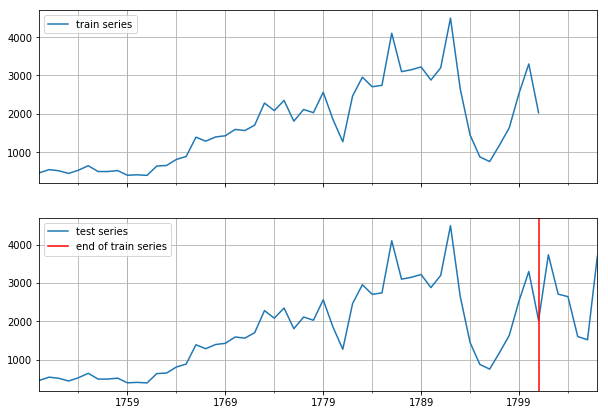

In [40]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [41]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-31 00:00:00
target: [459. 543. 512. 443. 528. 644. 493.]
feat_static_cat: [1]
length: 1236


In [42]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

# Study 1:`epochs=100, num_batches=50`

In [23]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts11-own-m4_subsets_sagemaker.ipynb

[NbConvertApp] Converting notebook gluonts11-own-m4_subsets_sagemaker.ipynb to html
[NbConvertApp] Writing 466870 bytes to ../html_outputs/gluonts11-own-m4_subsets_sagemaker.html


# Study 2: Increase `num_batches=100` 

In [27]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts11-own-m4_subsets_sagemaker.ipynb

[NbConvertApp] Converting notebook gluonts11-own-m4_subsets_sagemaker.ipynb to html
[NbConvertApp] Writing 529109 bytes to ../html_outputs/gluonts11-own-m4_subsets_sagemaker.html


# Study 3: `passes>=100`

In [45]:
#########################
### deepstate wrapper ###

data = "m4_yearly_other"
seed = 44
epochs = 500
num_batches = 100
batch_size = 32


mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
    batch_size=batch_size,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = num_batches
# output["batch_size"] = batch_size

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.86it/s, avg_epoch_loss=0.248]
INFO:root:Epoch[0] Elapsed time 2.339 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.248387
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.84it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1] Elapsed time 2.283 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.155997
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.61it/s, avg_epoch_loss=-.801]
INFO:root:Epoch[2] Elapsed time 2.296 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.801356
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.80it/s, avg_epoch_loss=-1.3]
INFO:root:Epoch[3] Elapsed time 2.285 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_

KeyboardInterrupt: 

## Include validation dataset

In [ ]:
#########################
### deepstate wrapper ###

data = "m4_yearly_other"
seed = 42
epochs = 500
num_batches = 100
batch_size = 32


mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
    batch_size=batch_size,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(training_data=dataset.train, validation_data=dataset.test)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = num_batches
# output["batch_size"] = batch_size

pd.DataFrame([output])

In [ ]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts11-own-m4_subsets_sagemaker.ipynb